In [1]:
import fit_classes as fp
import numpy as np
import os
import pandas as pd

errors = []
ERROR = 1 
def data_from_file(file):
    file_path = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), file)
    name = str(file_path).split("/")[-1].split("\\")[-1]
    df = pd.read_csv(file_path, delimiter=';', decimal=',')
    df.columns = df.columns.str.strip()

    SKIP1 = 1
    SKIP2_ =17
    SKIP2 = SKIP2_

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "superposition.txt")
    vals = []
    var = None
    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(int, line.strip().split(": ")[-1].strip("()").split(", ")))))

    check = False

    for var in vals:
        if var[0] == name:
            SKIP1, SKIP2 = var[1]
            check = True

    if not check:
        if True:
            values = (SKIP1, SKIP2)
            with open(file_p, "a") as file:
                file.write(f"{name}: {values}\n")

    x1 = df["Latest: Time (s)"].to_numpy()[::SKIP1]
    x2 = df["Latest: Time (s)"].to_numpy()[::SKIP2]
    y1 = df["Latest: Potential 1 (V)"].to_numpy()[::SKIP1]
    y2 = df["Latest: Potential 2 (V)"].to_numpy()[::SKIP2]
    dy1 = ERROR*np.ones_like(y1)
    dy2 = ERROR*np.ones_like(y2)

    # data1 = fp.Data(x1, y1, dy1, name=str(file_path).split('/')[-1][0:-4].split("\\")[-1] + '_1')
    # data2 = fp.Data(x2, y2, dy2, name=str(file_path).split('/')[-1][0:-4].split("\\")[-1]  + '_2')
    data1 = fp.Data(x1, y1, dy1, name=os.path.splitext(os.path.basename(file_path))[0] + '_1')
    data2 = fp.Data(x2, y2, dy2, name=os.path.splitext(os.path.basename(file_path))[0] + '_2')

    if not check:
        print(data2.name)
        data2.show()
    return data1, data2

        
def load_data_by_folder(root):
    folder_data = {}
    total_files = 0
    total_files += len([f for f in os.listdir(root)])

    current_file = 0
    data_list_input = []
    data_list = []
    for file in os.listdir(root):
        file_path = os.path.join(root, file)
        if os.path.isfile(file_path) and file.lower().endswith(".csv"):
            current_file += 1
            # os.system(f'echo "File: {current_file:>3}/{total_files}"')
            data1, data2 = data_from_file(file_path)
            data_list_input.append(data1)
            data_list.append(data2)
        
    if data_list:
        folder_data = np.array(data_list)
    return folder_data

data_arrays = load_data_by_folder(os.path.join(os.path.abspath(os.getcwd()), "data"))


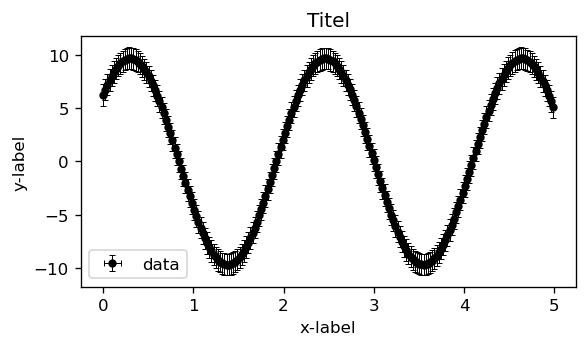

In [2]:
datadict = {}
for dataset in data_arrays:
    datadict[dataset.name[0:-2]] = dataset # ON windows
    # if dataset[1].name == '2-5_190Hz_2':
    # print(dataset.name)
    # dataset.show()
         
datadict["2-3_250Hz"].show()

# Opgave 1

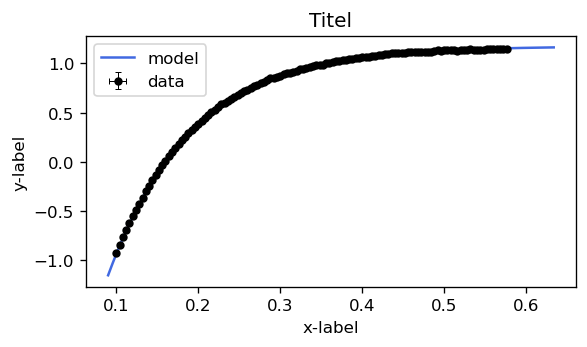

----------------------------------------------------------------------------------------------------------------
For parameter tau      :     $      0.10244 \pm      0.00039 $
For parameter a        :     $      1.17432 \pm      0.00180 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          51.20400389
Reduced χ² value       :     χ²_red           0.43393224
P-value                :     p-value          0.99999999
----------------------------------------------------------------------------------------------------------------



In [7]:
ERROR = 0.01
dataset = fp.Data(datadict["2-1"].x[25:145], datadict["2-1"].y[25:145], ERROR*datadict["2-1"].dy[25:145])

def model_opgave1(params, x):
    tau,a = params
    return (1-np.exp(-(x-0.160)/tau))*a

dataset.fit(model_opgave1).show()
print(dataset.fit(model_opgave1))

# Opgave 2

In [8]:
ERROR = 0.01
files = []
files_opdracht2 = []
for key in datadict:
    if key[0:3] == "2-2":
        files.append(fp.Data(datadict[key].x, datadict[key].y, ERROR*datadict[key].dy, name=datadict[key].name))

def sinus_model(params, x):
    A,f,phi,c = params
    return A*np.sin(2*np.pi*f*x + phi) + c

        
for dataset in files:
    A = 1.25
    f = 6
    phi = np.pi
    c = 0

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "guesses_opgave2.txt")
    vals = []
    var = None
    check = True

    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(float, line.strip().split(": ")[-1].strip("()").split(", ")))))
    for var in vals:
        if var[0] == dataset.name:
            A, f, phi, c = var[1]
            check = False

    dataset_new = dataset.fit(sinus_model, initial_guess=[A, f, phi, c])
    files_opdracht2.append(dataset_new)
    if dataset_new.chi2_red > 10:
        check = False
            
    if check:
        values = tuple([_ for _ in dataset_new.minima])
        with open(file_p, "a") as file:
            file.write(f"{dataset.name}: {values}\n")

    # WARNING: shows all fits
    if dataset_new.chi2_red > 0:
        print(dataset.name)
        print(dataset_new)
        # dataset_new.show(size=1)
        print("\n\n\n")

2-2_1.5Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      0.88560 \pm      0.00087 $
For parameter f        :     $      1.50309 \pm      0.00005 $
For parameter phi      :     $      1.98181 \pm      0.00098 $
For parameter c        :     $      0.00949 \pm      0.00061 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         490.35261397
Reduced χ² value       :     χ²_red           0.39322583
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------





2-2_10Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      1.24865 \pm      0.00087 $
For parameter f        :     $    

In [5]:
# print(files_opdracht2)

# Opgave 3

2-3_100Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.69685 \pm      0.03089 $
For parameter f        :     $      2.57618 \pm      0.00043 $
For parameter phi      :     $     -3.00163 \pm      0.00314 $
For parameter c        :     $      0.00937 \pm      0.02167 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          15.13718879
Reduced χ² value       :     χ²_red           0.15767905
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



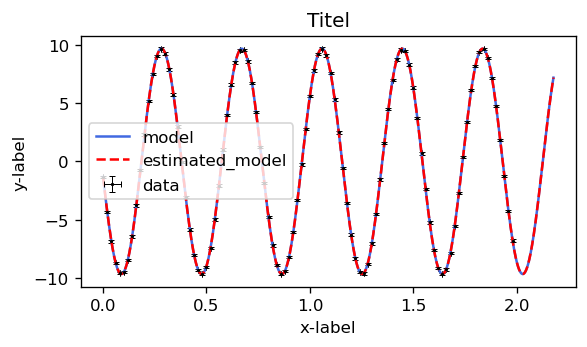





2-3_200Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.67223 \pm      0.03033 $
For parameter f        :     $      0.97676 \pm      0.00046 $
For parameter phi      :     $     -0.02212 \pm      0.00320 $
For parameter c        :     $      0.03991 \pm      0.02167 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         714.55773525
Reduced χ² value       :     χ²_red           7.44330974
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



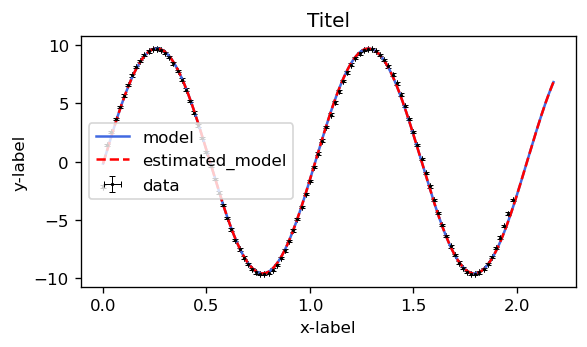





2-3_210Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $     -8.57964 \pm      0.03099 $
For parameter f        :     $      1.22119 \pm      0.00060 $
For parameter phi      :     $     -1.53197 \pm      0.00353 $
For parameter c        :     $     -0.34964 \pm      0.02167 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min       38379.70489311
Reduced χ² value       :     χ²_red         399.78859264
P-value                :     p-value          0.00000000
----------------------------------------------------------------------------------------------------------------



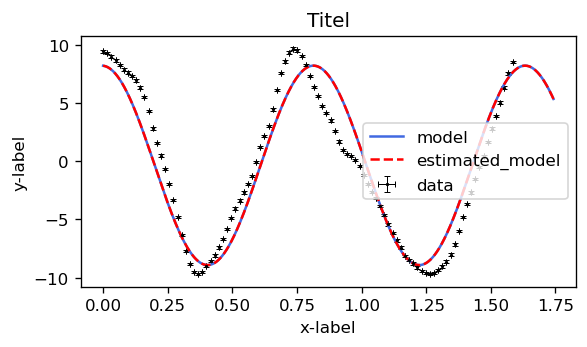





2-3_220Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.69530 \pm      0.03066 $
For parameter f        :     $      1.59376 \pm      0.00024 $
For parameter phi      :     $     -2.93694 \pm      0.00316 $
For parameter c        :     $      0.00297 \pm      0.02167 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          26.91493486
Reduced χ² value       :     χ²_red           0.28036390
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



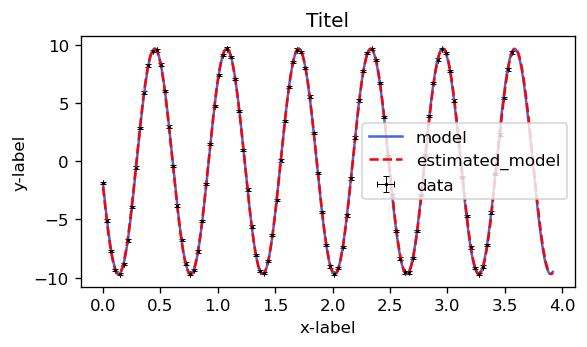





2-3_240Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.83938 \pm      0.03075 $
For parameter f        :     $      1.54819 \pm      0.00026 $
For parameter phi      :     $     -1.66139 \pm      0.00310 $
For parameter c        :     $      0.01605 \pm      0.02167 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min         112.52870091
Reduced χ² value       :     χ²_red           1.17217397
P-value                :     p-value          0.11939316
----------------------------------------------------------------------------------------------------------------



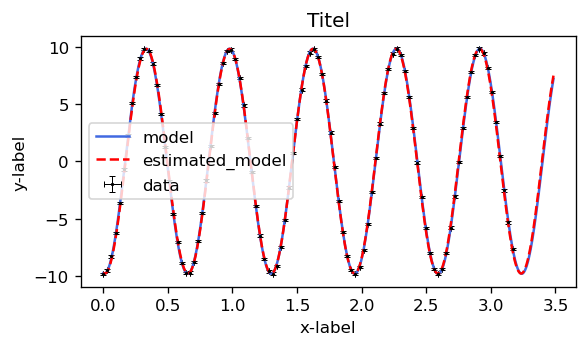

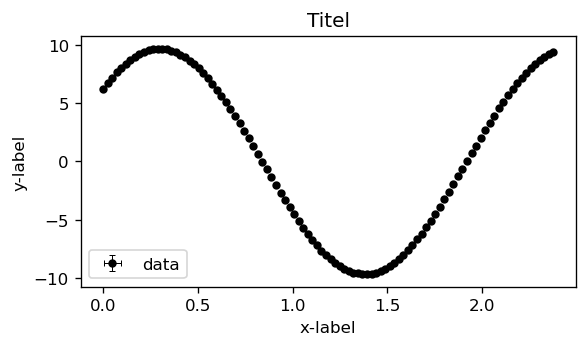

2-3_280Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.63326 \pm      0.03938 $
For parameter f        :     $      0.08179 \pm      0.00023 $
For parameter phi      :     $     -1.03920 \pm      0.00340 $
For parameter c        :     $      0.13138 \pm      0.02519 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min           5.13662382
Reduced χ² value       :     χ²_red           0.07338034
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



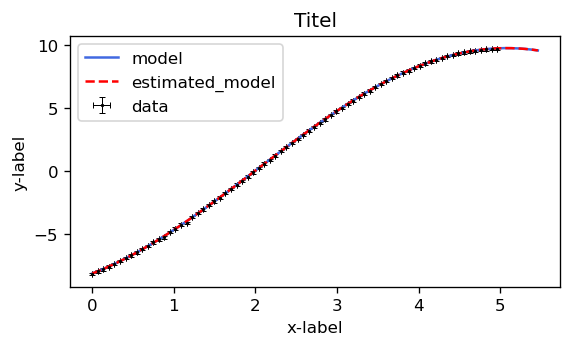





2-3_300Hz_2
----------------------------------------------------------------------------------------------------------------
For parameter A        :     $      9.66249 \pm      0.03150 $
For parameter f        :     $      0.38783 \pm      0.00023 $
For parameter phi      :     $      4.74063 \pm      0.00309 $
For parameter c        :     $      0.04182 \pm      0.02167 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min          98.20719207
Reduced χ² value       :     χ²_red           1.02299158
P-value                :     p-value          0.41834437
----------------------------------------------------------------------------------------------------------------



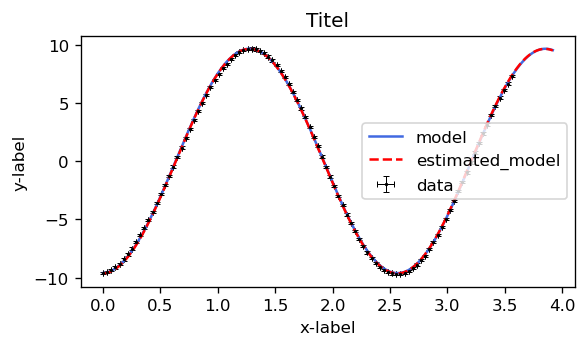

In [6]:
ERROR = 0.1
files = []
files_opdracht2 = []
for key in datadict:
    if key[0:3] == "2-3":
        files.append(fp.Data(datadict[key].x[:100], datadict[key].y[:100], ERROR*datadict[key].dy[:100], name=datadict[key].name))

def sinus_model(params, x):
    A,f,phi,c = params
    return A*np.sin(2*np.pi*f*x + phi) + c

        
for dataset in files:
    A = 10
    f = 1
    phi = -np.pi/4
    c = 1

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "guesses_opgave3.txt")
    vals = []
    var = None
    check = True

    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(float, line.strip().split(": ")[-1].strip("()").split(", ")))))
    for var in vals:
        if var[0] == dataset.name:
            A, f, phi, c = var[1]
            check = False

    # dataset.show()
    try:
        dataset_new = dataset.fit(sinus_model, initial_guess=[A, f, phi, c])
        files_opdracht2.append(dataset_new)
        if dataset_new.chi2_red > 10:
            check = False
                
        if check:
            values = tuple([_ for _ in dataset_new.minima])
            with open(file_p, "a") as file:
                file.write(f"{dataset.name}: {values}\n")

        # WARNING: shows all fits
        if dataset_new.chi2_red > 0:
            print(dataset.name)
            print(dataset_new)
            dataset_new.show(size=1, fit_guess=True)
            print("\n\n\n")
    except ValueError:
        dataset.show()